# The ElasticNet interpretations (for the most abundant cell types)

## Outline

The **MLAging - cell type** workflow consists of sections:

`00 preprocessing.R` Data preprocessing and preparation in Seurat.

`21 Cell Type ELN Tuning` ELN model tunning using *binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`22 Cell Type ELN Result 10x` Run the best models for *binarized* HVGs over 10 random seeds.

`23 Cell Type Result Viz` Result visulization.

`24 Cell Type Interpretations` Result interpretation **this notebook**:
- [ELN model coefficients (all genes)](#1.-ce)
- [ELN model coefficients (top 20 genes)](#2.-top20)
- [In Silico Perturbation](#3.-pert)

In [1]:
import sys
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from src.interpretation import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
data_type = 'float32'

### a) ELN model coefficients (all genes) <a name="1.-ce"></a>

In [2]:
cell_types = ['Neuron', 'Oligodendrocyte', 'Astrocyte', 'OPC', 'Microglia']
for i in cell_types:
    file = open('../results/cell_type_best/'+ i + '_eln_model_test_models.save', 'rb')
    final_models = pickle.load(file)
    file.close()
    
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final_data  = pickle.load(file)
    file.close() 
    
    locals()[i] = coefs_list_10(final_data, final_models)

In [3]:
X = final_data[0][0]

In [4]:
outer_colors = ['#3182bd', '#e6550d', '#31a354', '#756bb1', '#bdbdbd']

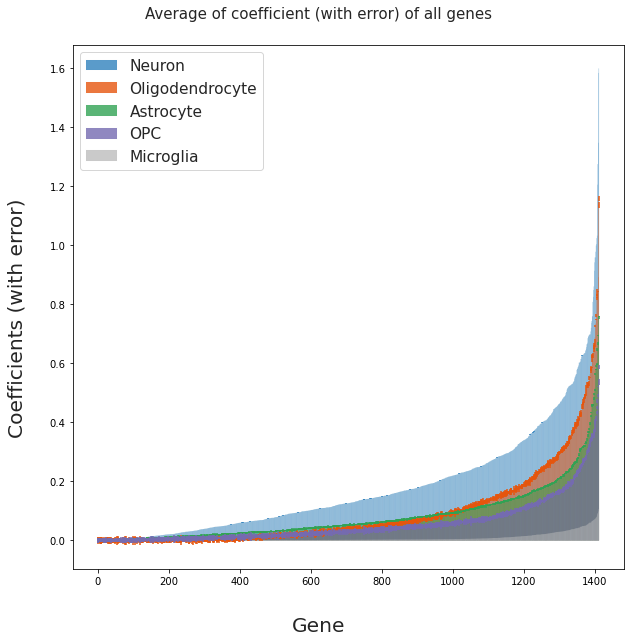

In [5]:
fig, axs  = plt.subplots(figsize=(9,9), sharex=True)
sns.set(font_scale=1.4, style='ticks')

for i in cell_types:
    mean_coefs, std_coefs = locals()[i]
    abs_coefs = np.absolute(mean_coefs)
    
    number = cell_types.index(i)
    color = outer_colors[number]

    axs.bar(np.arange(1413), np.sort(abs_coefs), yerr=std_coefs, snap=False, capsize=-.005,
            alpha=0.8,
            color=color, 
            edgecolor=color,
            linewidth=0.005,
            ecolor=color)

fig.supxlabel('Gene')
fig.supylabel('Coefficients (with error)')
plt.legend(cell_types)
fig.suptitle('Average of coefficient (with error) of all genes', fontsize=15)

plt.tight_layout()
#plt.savefig('../figures/4d_celltype_waterfall_abs.pdf')

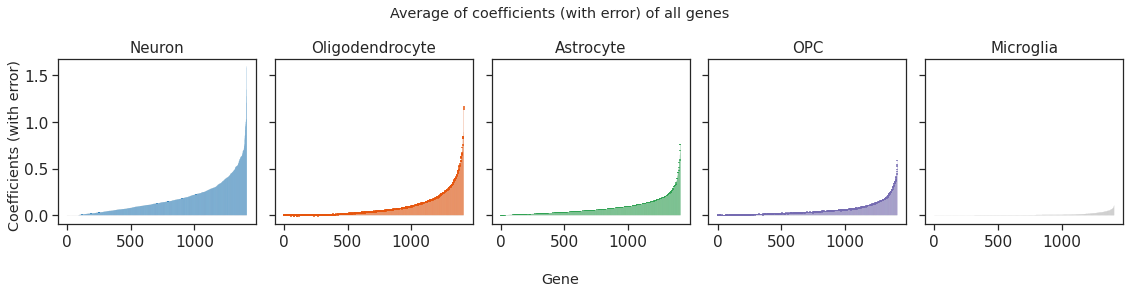

In [6]:
fig, axs  = plt.subplots(1,5, figsize=(16,4), sharex=True, sharey=True)
sns.set(font_scale=1, style='ticks')

for i in cell_types:
    mean_coefs, std_coefs = locals()[i]
    abs_coefs = np.absolute(mean_coefs)
    
    number = cell_types.index(i)
    color = outer_colors[number]
    axs[number].bar(np.arange(1413), np.sort(abs_coefs), yerr=std_coefs, snap=False, capsize=-.005,
        color=color, 
        edgecolor=color,
        linewidth=0.005,
        ecolor=color)
    
    axs[number].set_title(f'{i}', fontsize=15)
#     axs[number].set_ylim(min(abs_coefs)-0.3*(max(abs_coefs)-min(abs_coefs)), 
#                          max(abs_coefs)+0.3*(max(abs_coefs)-min(abs_coefs)))

fig.supxlabel('Gene')
fig.supylabel('Coefficients (with error)')
fig.suptitle('Average of coefficients (with error) of all genes')

plt.tight_layout()
#plt.savefig('../figures/4d_celltype_waterfall, color.pdf')

### b) ELN model coefficients (top 20 genes) <a name="2.-top20"></a>

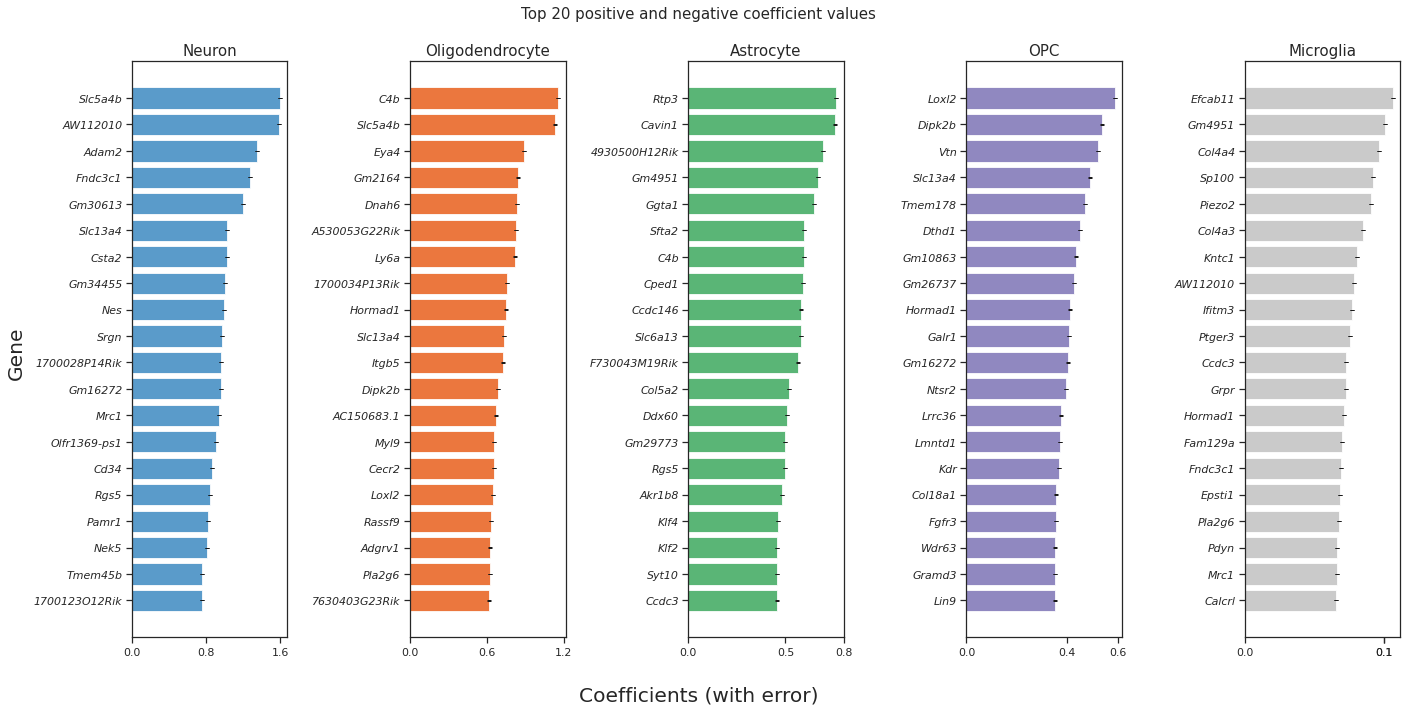

In [7]:
fig, axs  = plt.subplots(1,5, figsize=(20,10))
sns.set(font_scale=1.4, style='ticks')

for i in cell_types:
    mean_coefs, std_coefs = locals()[i]
    abs_coefs = np.absolute(mean_coefs)
    abs_thetas_tuple = [(i,coef) for i,coef in enumerate(abs_coefs)]
    results = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)

    nr_coefs = 20
    
    top_coefs_result = [(result, X.columns[result[0]]) for result in results][:nr_coefs]
    top_coefs_result.reverse()
    top_coefs = [abs_coefs[t[0][0]] for t in top_coefs_result]
    top_features = [t[1] for t in top_coefs_result]
    std_top_coefs = [std_coefs[t[0][0]] for t in top_coefs_result]

    number = cell_types.index(i)
    axs[number].barh(np.arange(nr_coefs), top_coefs, yerr=std_top_coefs, 
                     capsize=2, color=outer_colors[number], alpha=0.8)
    axs[number].set_yticks(np.arange(nr_coefs))
    axs[number].set_yticklabels(top_features, style='italic',)
    
    axs[number].set_xticks((round(min(top_coefs), 1), 0, round(max(top_coefs), 1)))

    axs[number].set_title(f'{i}', fontsize=15)

fig.supxlabel('Coefficients (with error)')
fig.supylabel('Gene')
fig.suptitle('Top 20 positive and negative coefficient values', fontsize=15)
plt.tight_layout()
#plt.savefig('../figures/4e_celltype_top_waterfall_abs.pdf')

### c) In Silico Perturbation <a name="3.-pert"></a>

In [8]:
score_list = []
ftr_names_list = []
for i in cell_types:
    file = open('../results/cell_type_best/'+ i + '_eln_model_test_models.save', 'rb')
    final_models = pickle.load(file)
    file.close()
    
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final_data  = pickle.load(file)
    file.close() 
    
    X_test, y_test = final_data[0]
    grid = final_models[0]
    
    X_test_shuffled = X_test.copy()
    
    mean_coefs, std_coefs = locals()[i]
    
    ftr_names = abs_coefs_list(mean_coefs, X)
    ftr_names.reverse()
    nr_runs = 10
    scores = np.zeros([len(ftr_names), nr_runs])
    
    for i in range(len(ftr_names)):
        print('shuffling '+ str(ftr_names[i]))
        auprc_scores = []
        for j in range(nr_runs):
            X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
            y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
            precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
            auprc_scores.append(auc(recall, precision))
        print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
        scores[i] = auprc_scores
    score_list.append(scores)
    ftr_names_list.append(ftr_names)

False    1349
True       64
dtype: int64
shuffling Ddah1
shuffled test score: 0.9667 +/- 0.0
shuffling Slc25a13
shuffled test score: 0.9667 +/- 0.0
shuffling Mro
shuffled test score: 0.9667 +/- 0.0
shuffling Ccdc60
shuffled test score: 0.9667 +/- 0.0
shuffling Zfp36l1
shuffled test score: 0.9667 +/- 0.0
shuffling Slc13a1
shuffled test score: 0.9667 +/- 0.0
shuffling Dgkg
shuffled test score: 0.9667 +/- 0.0
shuffling Tgfb2
shuffled test score: 0.9667 +/- 0.0
shuffling Brinp2
shuffled test score: 0.9667 +/- 0.0
shuffling Tril
shuffled test score: 0.9667 +/- 0.0
shuffling Slc2a1
shuffled test score: 0.9667 +/- 0.0
shuffling Nckap1l
shuffled test score: 0.9667 +/- 0.0
shuffling Cnih3
shuffled test score: 0.9667 +/- 0.0
shuffling Hmcn2
shuffled test score: 0.9667 +/- 0.0
shuffling Ret
shuffled test score: 0.9667 +/- 0.0
shuffling Ar
shuffled test score: 0.9667 +/- 0.0
shuffling Gli3
shuffled test score: 0.9667 +/- 0.0
shuffling Has2os
shuffled test score: 0.9667 +/- 0.0
shuffling Nos1
shuff

shuffled test score: 0.9667 +/- 0.0
shuffling Alk
shuffled test score: 0.9667 +/- 0.0
shuffling Nek11
shuffled test score: 0.9667 +/- 0.0
shuffling Wwc1
shuffled test score: 0.9667 +/- 0.0
shuffling Syt10
shuffled test score: 0.9667 +/- 0.0
shuffling Zbbx
shuffled test score: 0.9667 +/- 0.0
shuffling Auts2
shuffled test score: 0.9667 +/- 0.0
shuffling Kcnb2
shuffled test score: 0.9667 +/- 0.0
shuffling Kcnt2
shuffled test score: 0.9667 +/- 0.0
shuffling Man2a1
shuffled test score: 0.9668 +/- 0.0
shuffling Slc25a21
shuffled test score: 0.9668 +/- 0.0
shuffling Lmx1a
shuffled test score: 0.9668 +/- 0.0
shuffling Lgr5
shuffled test score: 0.9668 +/- 0.0
shuffling Nin
shuffled test score: 0.9668 +/- 0.0
shuffling Pvt1
shuffled test score: 0.9668 +/- 0.0
shuffling Ecel1
shuffled test score: 0.9668 +/- 0.0
shuffling Fam189a1
shuffled test score: 0.9668 +/- 0.0
shuffling C030029H02Rik
shuffled test score: 0.9668 +/- 0.0
shuffling Sdk2
shuffled test score: 0.9667 +/- 0.0
shuffling Pde1a
shuffl

shuffled test score: 0.9665 +/- 0.0
shuffling C1ql1
shuffled test score: 0.9665 +/- 0.0
shuffling Nrxn3
shuffled test score: 0.9665 +/- 0.0
shuffling Schip1
shuffled test score: 0.9665 +/- 0.0
shuffling Epha10
shuffled test score: 0.9664 +/- 0.0
shuffling Zswim6
shuffled test score: 0.9664 +/- 0.0
shuffling Frmpd4
shuffled test score: 0.9665 +/- 0.0
shuffling Mthfd1l
shuffled test score: 0.9665 +/- 0.0
shuffling Gm5149
shuffled test score: 0.9665 +/- 0.0
shuffling Spats2l
shuffled test score: 0.9665 +/- 0.0
shuffling Prkg1
shuffled test score: 0.9665 +/- 0.0
shuffling Gpc4
shuffled test score: 0.9665 +/- 0.0
shuffling Scn5a
shuffled test score: 0.9665 +/- 0.0
shuffling Vwa3a
shuffled test score: 0.9665 +/- 0.0
shuffling Slc1a2
shuffled test score: 0.9665 +/- 0.0
shuffling A330102I10Rik
shuffled test score: 0.9665 +/- 0.0
shuffling Fam216b
shuffled test score: 0.9666 +/- 0.0
shuffling Cdh19
shuffled test score: 0.9666 +/- 0.0
shuffling Cdh12
shuffled test score: 0.9665 +/- 0.0
shuffling

shuffled test score: 0.9664 +/- 0.0
shuffling Hlf
shuffled test score: 0.9664 +/- 0.0
shuffling Fmod
shuffled test score: 0.9663 +/- 0.0
shuffling Sorcs3
shuffled test score: 0.9663 +/- 0.0
shuffling Ccdc114
shuffled test score: 0.9663 +/- 0.0
shuffling Atrnl1
shuffled test score: 0.9663 +/- 0.0
shuffling Sema5a
shuffled test score: 0.9663 +/- 0.0
shuffling Sparc
shuffled test score: 0.9663 +/- 0.0
shuffling Agt
shuffled test score: 0.9663 +/- 0.0
shuffling Plcl1
shuffled test score: 0.9664 +/- 0.0
shuffling Lrrc7
shuffled test score: 0.9663 +/- 0.0
shuffling Kcnh7
shuffled test score: 0.9663 +/- 0.0
shuffling Zfp423
shuffled test score: 0.9663 +/- 0.0
shuffling Syt6
shuffled test score: 0.9663 +/- 0.0
shuffling Camk4
shuffled test score: 0.9663 +/- 0.0
shuffling Gm10714
shuffled test score: 0.9663 +/- 0.0
shuffling Tmem196
shuffled test score: 0.9663 +/- 0.0
shuffling Dipk2b
shuffled test score: 0.9663 +/- 0.0
shuffling Sel1l3
shuffled test score: 0.9663 +/- 0.0
shuffling Strip2
shuff

shuffled test score: 0.9612 +/- 0.0
shuffling Slc2a13
shuffled test score: 0.9611 +/- 0.0
shuffling Prkd1
shuffled test score: 0.961 +/- 0.0
shuffling Abcg2
shuffled test score: 0.9611 +/- 0.0
shuffling Oprk1
shuffled test score: 0.9609 +/- 0.0
shuffling Gm29683
shuffled test score: 0.961 +/- 0.0
shuffling Plcxd3
shuffled test score: 0.9608 +/- 0.0
shuffling Adamts3
shuffled test score: 0.961 +/- 0.0
shuffling Gria3
shuffled test score: 0.9611 +/- 0.0
shuffling Gm19410
shuffled test score: 0.961 +/- 0.0
shuffling Mob3b
shuffled test score: 0.961 +/- 0.0
shuffling Nxn
shuffled test score: 0.961 +/- 0.0
shuffling Rbpms
shuffled test score: 0.961 +/- 0.0
shuffling Glis3
shuffled test score: 0.9609 +/- 0.0
shuffling Pik3ap1
shuffled test score: 0.9609 +/- 0.0
shuffling Eya2
shuffled test score: 0.9609 +/- 0.0
shuffling Gm973
shuffled test score: 0.9609 +/- 0.0
shuffling Slc35f4
shuffled test score: 0.9608 +/- 0.0
shuffling Emcn
shuffled test score: 0.9607 +/- 0.0
shuffling Aspa
shuffled te

shuffled test score: 0.9577 +/- 0.0
shuffling Loxl2
shuffled test score: 0.9579 +/- 0.0
shuffling Kctd16
shuffled test score: 0.9578 +/- 0.0
shuffling Gm49313
shuffled test score: 0.9576 +/- 0.0
shuffling 9530026P05Rik
shuffled test score: 0.9576 +/- 0.0001
shuffling Arhgap6
shuffled test score: 0.9575 +/- 0.0
shuffling 8030442B05Rik
shuffled test score: 0.9576 +/- 0.0
shuffling Mme
shuffled test score: 0.9576 +/- 0.0
shuffling Pgm5
shuffled test score: 0.9573 +/- 0.0
shuffling Onecut1
shuffled test score: 0.9571 +/- 0.0
shuffling Arhgef3
shuffled test score: 0.957 +/- 0.0
shuffling Shroom3
shuffled test score: 0.9569 +/- 0.0
shuffling Plekhh1
shuffled test score: 0.9569 +/- 0.0
shuffling Gm2164
shuffled test score: 0.9567 +/- 0.0
shuffling Shisa9
shuffled test score: 0.9567 +/- 0.0001
shuffling Slit2
shuffled test score: 0.9569 +/- 0.0
shuffling Arhgef37
shuffled test score: 0.9568 +/- 0.0
shuffling Cdk6
shuffled test score: 0.9567 +/- 0.0
shuffling Acss3
shuffled test score: 0.9567 +

shuffled test score: 0.9327 +/- 0.0001
shuffling Klf2
shuffled test score: 0.9322 +/- 0.0001
shuffling 4930500H12Rik
shuffled test score: 0.9303 +/- 0.0001
shuffling Dnah14
shuffled test score: 0.9292 +/- 0.0001
shuffling Knl1
shuffled test score: 0.9267 +/- 0.0001
shuffling 2010001K21Rik
shuffled test score: 0.927 +/- 0.0
shuffling Col12a1
shuffled test score: 0.9262 +/- 0.0001
shuffling Ros1
shuffled test score: 0.9244 +/- 0.0001
shuffling Tnfsf4
shuffled test score: 0.9236 +/- 0.0001
shuffling Zfp366
shuffled test score: 0.922 +/- 0.0001
shuffling C1qa
shuffled test score: 0.9223 +/- 0.0001
shuffling Vipr2
shuffled test score: 0.9212 +/- 0.0001
shuffling Erg
shuffled test score: 0.9187 +/- 0.0001
shuffling Grpr
shuffled test score: 0.9171 +/- 0.0001
shuffling Ccdc3
shuffled test score: 0.9145 +/- 0.0001
shuffling Col6a5
shuffled test score: 0.9126 +/- 0.0002
shuffling Greb1
shuffled test score: 0.9112 +/- 0.0002
shuffling Foxq1
shuffled test score: 0.9137 +/- 0.0001
shuffling Postn


shuffled test score: 0.9855 +/- 0.0
shuffling 4930447C04Rik
shuffled test score: 0.9855 +/- 0.0
shuffling Rbm47
shuffled test score: 0.9855 +/- 0.0
shuffling Ttc6
shuffled test score: 0.9855 +/- 0.0
shuffling Gm20757
shuffled test score: 0.9855 +/- 0.0
shuffling Tacr1
shuffled test score: 0.9855 +/- 0.0
shuffling Onecut1
shuffled test score: 0.9855 +/- 0.0
shuffling Agtr1b
shuffled test score: 0.9855 +/- 0.0
shuffling Fam163a
shuffled test score: 0.9855 +/- 0.0
shuffling Trpc4
shuffled test score: 0.9855 +/- 0.0
shuffling Met
shuffled test score: 0.9855 +/- 0.0
shuffling Gm4951
shuffled test score: 0.9855 +/- 0.0
shuffling Tbx19
shuffled test score: 0.9855 +/- 0.0
shuffling Pdzd2
shuffled test score: 0.9855 +/- 0.0
shuffling Syndig1
shuffled test score: 0.9855 +/- 0.0
shuffling Fgd2
shuffled test score: 0.9855 +/- 0.0
shuffling Trpc6
shuffled test score: 0.9855 +/- 0.0
shuffling Lmx1a
shuffled test score: 0.9855 +/- 0.0
shuffling Entpd1
shuffled test score: 0.9855 +/- 0.0
shuffling Cst

shuffled test score: 0.9855 +/- 0.0
shuffling Gm19303
shuffled test score: 0.9855 +/- 0.0
shuffling Cntn3
shuffled test score: 0.9855 +/- 0.0
shuffling Kcnmb2
shuffled test score: 0.9855 +/- 0.0
shuffling Cpne9
shuffled test score: 0.9855 +/- 0.0
shuffling Cep95
shuffled test score: 0.9855 +/- 0.0
shuffling Gpc3
shuffled test score: 0.9855 +/- 0.0
shuffling Hcrt
shuffled test score: 0.9855 +/- 0.0
shuffling Inpp5d
shuffled test score: 0.9855 +/- 0.0
shuffling Dock5
shuffled test score: 0.9855 +/- 0.0
shuffling Slc7a5
shuffled test score: 0.9855 +/- 0.0
shuffling Slc16a10
shuffled test score: 0.9855 +/- 0.0
shuffling Esrrg
shuffled test score: 0.9855 +/- 0.0
shuffling Gm2516
shuffled test score: 0.9855 +/- 0.0
shuffling Gm10649
shuffled test score: 0.9855 +/- 0.0
shuffling Gm34455
shuffled test score: 0.9855 +/- 0.0
shuffling Gm7854
shuffled test score: 0.9855 +/- 0.0
shuffling Cacng3
shuffled test score: 0.9855 +/- 0.0
shuffling Tox3
shuffled test score: 0.9855 +/- 0.0
shuffling Kcnip3

shuffled test score: 0.9855 +/- 0.0
shuffling Itga9
shuffled test score: 0.9855 +/- 0.0
shuffling Lhfpl3
shuffled test score: 0.9855 +/- 0.0
shuffling Pvt1
shuffled test score: 0.9854 +/- 0.0
shuffling Adamts17
shuffled test score: 0.9854 +/- 0.0
shuffling Tafa1
shuffled test score: 0.9854 +/- 0.0
shuffling Il1rapl2
shuffled test score: 0.9854 +/- 0.0
shuffling Man2a1
shuffled test score: 0.9854 +/- 0.0
shuffling Sphkap
shuffled test score: 0.9854 +/- 0.0
shuffling Selplg
shuffled test score: 0.9854 +/- 0.0
shuffling Dlgap2
shuffled test score: 0.9854 +/- 0.0
shuffling Calcrl
shuffled test score: 0.9854 +/- 0.0
shuffling Htr7
shuffled test score: 0.9854 +/- 0.0
shuffling Unc5cl
shuffled test score: 0.9854 +/- 0.0
shuffling Unc13b
shuffled test score: 0.9854 +/- 0.0
shuffling Slc44a5
shuffled test score: 0.9854 +/- 0.0
shuffling Hs3st5
shuffled test score: 0.9854 +/- 0.0
shuffling Ptprg
shuffled test score: 0.9854 +/- 0.0
shuffling A830019P07Rik
shuffled test score: 0.9854 +/- 0.0
shuff

shuffled test score: 0.9853 +/- 0.0
shuffling Dlx6os1
shuffled test score: 0.9853 +/- 0.0
shuffling Sfmbt2
shuffled test score: 0.9853 +/- 0.0
shuffling Rspo2
shuffled test score: 0.9853 +/- 0.0
shuffling 6330411D24Rik
shuffled test score: 0.9853 +/- 0.0
shuffling Pkib
shuffled test score: 0.9853 +/- 0.0
shuffling Adamts18
shuffled test score: 0.9853 +/- 0.0
shuffling Sncaip
shuffled test score: 0.9853 +/- 0.0
shuffling Pde7b
shuffled test score: 0.9853 +/- 0.0
shuffling Cntn5
shuffled test score: 0.9853 +/- 0.0
shuffling Edaradd
shuffled test score: 0.9853 +/- 0.0
shuffling Adap2
shuffled test score: 0.9853 +/- 0.0
shuffling Cdh6
shuffled test score: 0.9853 +/- 0.0
shuffling Cdh23
shuffled test score: 0.9853 +/- 0.0
shuffling Gm10754
shuffled test score: 0.9853 +/- 0.0
shuffling Atp1a2
shuffled test score: 0.9853 +/- 0.0
shuffling Slc1a3
shuffled test score: 0.9853 +/- 0.0
shuffling Agt
shuffled test score: 0.9853 +/- 0.0
shuffling Ntn1
shuffled test score: 0.9853 +/- 0.0
shuffling Ki

shuffled test score: 0.9852 +/- 0.0
shuffling Gm41414
shuffled test score: 0.9852 +/- 0.0
shuffling Gfod2
shuffled test score: 0.9852 +/- 0.0
shuffling C730034F03Rik
shuffled test score: 0.9852 +/- 0.0
shuffling Gm16272
shuffled test score: 0.9851 +/- 0.0
shuffling Luzp2
shuffled test score: 0.9851 +/- 0.0
shuffling Id2
shuffled test score: 0.9851 +/- 0.0
shuffling Kcnk2
shuffled test score: 0.9851 +/- 0.0
shuffling 1700047M11Rik
shuffled test score: 0.9851 +/- 0.0
shuffling Rhbdl3
shuffled test score: 0.9851 +/- 0.0
shuffling Arhgef26
shuffled test score: 0.9851 +/- 0.0
shuffling Fmn1
shuffled test score: 0.9852 +/- 0.0
shuffling Trabd2b
shuffled test score: 0.9851 +/- 0.0
shuffling Cobll1
shuffled test score: 0.9851 +/- 0.0
shuffling Myo1b
shuffled test score: 0.9852 +/- 0.0
shuffling Cacna2d1
shuffled test score: 0.9852 +/- 0.0
shuffling Msra
shuffled test score: 0.9852 +/- 0.0
shuffling Npsr1
shuffled test score: 0.9852 +/- 0.0
shuffling Prkcg
shuffled test score: 0.9852 +/- 0.0
sh

shuffled test score: 0.9853 +/- 0.0
shuffling Spink10
shuffled test score: 0.9853 +/- 0.0
shuffling Cldn5
shuffled test score: 0.9854 +/- 0.0
shuffling Pitpnc1
shuffled test score: 0.9854 +/- 0.0
shuffling Patj
shuffled test score: 0.9854 +/- 0.0
shuffling Sdk2
shuffled test score: 0.9854 +/- 0.0
shuffling Itga1
shuffled test score: 0.9853 +/- 0.0
shuffling Rgs7bp
shuffled test score: 0.9853 +/- 0.0
shuffling Arhgap28
shuffled test score: 0.9853 +/- 0.0
shuffling Parm1
shuffled test score: 0.9853 +/- 0.0
shuffling Calb1
shuffled test score: 0.9853 +/- 0.0
shuffling Mrc1
shuffled test score: 0.9853 +/- 0.0
shuffling Elavl4
shuffled test score: 0.9853 +/- 0.0
shuffling Pcdh11x
shuffled test score: 0.9854 +/- 0.0
shuffling Gm26512
shuffled test score: 0.9853 +/- 0.0
shuffling Syt2
shuffled test score: 0.9853 +/- 0.0
shuffling Cpne8
shuffled test score: 0.9853 +/- 0.0
shuffling Srgap1
shuffled test score: 0.9854 +/- 0.0
shuffling Phactr1
shuffled test score: 0.9854 +/- 0.0
shuffling Cdk19


shuffled test score: 0.9865 +/- 0.0
shuffling Nrn1
shuffled test score: 0.9864 +/- 0.0
shuffling Cfap43
shuffled test score: 0.9867 +/- 0.0
shuffling Pomc
shuffled test score: 0.9866 +/- 0.0
shuffling Slc35f1
shuffled test score: 0.9866 +/- 0.0
shuffling Nfib
shuffled test score: 0.9866 +/- 0.0
shuffling Ctss
shuffled test score: 0.9866 +/- 0.0
shuffling Meis2
shuffled test score: 0.9866 +/- 0.0
shuffling Cpne4
shuffled test score: 0.9866 +/- 0.0
shuffling Wif1
shuffled test score: 0.9866 +/- 0.0
shuffling Hcn1
shuffled test score: 0.9866 +/- 0.0
shuffling Dpyd
shuffled test score: 0.9866 +/- 0.0
shuffling Cx3cr1
shuffled test score: 0.9866 +/- 0.0
shuffling Sema3d
shuffled test score: 0.9866 +/- 0.0
shuffling Alcam
shuffled test score: 0.9866 +/- 0.0
shuffling Sema6d
shuffled test score: 0.9867 +/- 0.0
shuffling Hdac9
shuffled test score: 0.9866 +/- 0.0
shuffling Slc6a13
shuffled test score: 0.9866 +/- 0.0
shuffling Col25a1
shuffled test score: 0.9866 +/- 0.0
shuffling Ralyl
shuffled 

shuffled test score: 0.9875 +/- 0.0
shuffling Tgfbr2
shuffled test score: 0.9875 +/- 0.0
shuffling Kit
shuffled test score: 0.9874 +/- 0.0
shuffling Schip1
shuffled test score: 0.9875 +/- 0.0
shuffling Arpp21
shuffled test score: 0.9874 +/- 0.0
shuffling Rnf220
shuffled test score: 0.9876 +/- 0.0
shuffling Ifitm3
shuffled test score: 0.9875 +/- 0.0
shuffling Mb21d2
shuffled test score: 0.9876 +/- 0.0
shuffling Nrp2
shuffled test score: 0.9876 +/- 0.0
shuffling Lgals9
shuffled test score: 0.9876 +/- 0.0
shuffling Gm6145
shuffled test score: 0.9876 +/- 0.0
shuffling Pdgfc
shuffled test score: 0.9875 +/- 0.0
shuffling Ropn1
shuffled test score: 0.9872 +/- 0.0
shuffling Dscaml1
shuffled test score: 0.9874 +/- 0.0001
shuffling Chst8
shuffled test score: 0.9873 +/- 0.0
shuffling Corin
shuffled test score: 0.9873 +/- 0.0
shuffling Vip
shuffled test score: 0.9877 +/- 0.0
shuffling Col27a1
shuffled test score: 0.9877 +/- 0.0
shuffling St6galnac3
shuffled test score: 0.9878 +/- 0.0001
shuffling 

shuffled test score: 0.9843 +/- 0.0001
shuffling Arhgap31
shuffled test score: 0.984 +/- 0.0001
shuffling Olfr889
shuffled test score: 0.9834 +/- 0.0001
shuffling Qk
shuffled test score: 0.9837 +/- 0.0001
shuffling Wls
shuffled test score: 0.9836 +/- 0.0001
shuffling C1ql1
shuffled test score: 0.9832 +/- 0.0
shuffling Gm11290
shuffled test score: 0.9833 +/- 0.0001
shuffling Tll2
shuffled test score: 0.983 +/- 0.0001
shuffling Cldn14
shuffled test score: 0.9819 +/- 0.0001
shuffling Fn1
shuffled test score: 0.9815 +/- 0.0001
shuffling Tmem212
shuffled test score: 0.9813 +/- 0.0
shuffling Rad51b
shuffled test score: 0.981 +/- 0.0001
shuffling Prr5l
shuffled test score: 0.9813 +/- 0.0001
shuffling Gm10714
shuffled test score: 0.9803 +/- 0.0001
shuffling Phldb2
shuffled test score: 0.9817 +/- 0.0001
shuffling Cdkn3
shuffled test score: 0.9806 +/- 0.0001
shuffling Enpp2
shuffled test score: 0.9812 +/- 0.0001
shuffling 2810403D21Rik
shuffled test score: 0.9814 +/- 0.0001
shuffling Slc13a1
shu

shuffled test score: 0.9596 +/- 0.0
shuffling Kif26b
shuffled test score: 0.9596 +/- 0.0
shuffling Pde8a
shuffled test score: 0.9596 +/- 0.0
shuffling Mb21d2
shuffled test score: 0.9596 +/- 0.0
shuffling Gm29478
shuffled test score: 0.9595 +/- 0.0
shuffling Rorb
shuffled test score: 0.9595 +/- 0.0
shuffling Csta2
shuffled test score: 0.9596 +/- 0.0
shuffling Nckap1l
shuffled test score: 0.9596 +/- 0.0
shuffling Slc35f4
shuffled test score: 0.9596 +/- 0.0
shuffling Kirrel3
shuffled test score: 0.9595 +/- 0.0
shuffling Cdh4
shuffled test score: 0.9596 +/- 0.0
shuffling Epha10
shuffled test score: 0.9596 +/- 0.0
shuffling Calcrl
shuffled test score: 0.9596 +/- 0.0
shuffling Itga6
shuffled test score: 0.9595 +/- 0.0
shuffling Rerg
shuffled test score: 0.9595 +/- 0.0
shuffling Gzmk
shuffled test score: 0.9595 +/- 0.0
shuffling Col25a1
shuffled test score: 0.9595 +/- 0.0
shuffling Pmfbp1
shuffled test score: 0.9595 +/- 0.0
shuffling Tacr1
shuffled test score: 0.9595 +/- 0.0
shuffling Pbx3
sh

shuffled test score: 0.9594 +/- 0.0
shuffling Adamts17
shuffled test score: 0.9594 +/- 0.0
shuffling Slc38a11
shuffled test score: 0.9594 +/- 0.0
shuffling 6330411D24Rik
shuffled test score: 0.9594 +/- 0.0
shuffling Gm29865
shuffled test score: 0.9594 +/- 0.0
shuffling Dcn
shuffled test score: 0.9594 +/- 0.0
shuffling Wwtr1
shuffled test score: 0.9594 +/- 0.0
shuffling Phactr2
shuffled test score: 0.9594 +/- 0.0
shuffling Ly6e
shuffled test score: 0.9594 +/- 0.0
shuffling Pcdh7
shuffled test score: 0.9595 +/- 0.0
shuffling T2
shuffled test score: 0.9594 +/- 0.0
shuffling Scn7a
shuffled test score: 0.9595 +/- 0.0
shuffling Arhgap45
shuffled test score: 0.9594 +/- 0.0
shuffling Rtn4rl1
shuffled test score: 0.9595 +/- 0.0
shuffling Cdh12
shuffled test score: 0.9594 +/- 0.0
shuffling Fam216b
shuffled test score: 0.9594 +/- 0.0
shuffling Robo1
shuffled test score: 0.9594 +/- 0.0
shuffling Plcxd3
shuffled test score: 0.9594 +/- 0.0
shuffling Filip1
shuffled test score: 0.9594 +/- 0.0
shuffli

shuffled test score: 0.9592 +/- 0.0
shuffling Pcdh11x
shuffled test score: 0.9592 +/- 0.0
shuffling Gabra4
shuffled test score: 0.9592 +/- 0.0
shuffling Nectin3
shuffled test score: 0.9592 +/- 0.0
shuffling Ptchd1
shuffled test score: 0.9592 +/- 0.0
shuffling Lypd6
shuffled test score: 0.9592 +/- 0.0
shuffling Erg
shuffled test score: 0.9592 +/- 0.0
shuffling Susd1
shuffled test score: 0.9592 +/- 0.0
shuffling Bcl11a
shuffled test score: 0.9592 +/- 0.0
shuffling Cacna1c
shuffled test score: 0.9592 +/- 0.0
shuffling Slc2a1
shuffled test score: 0.9591 +/- 0.0
shuffling C1qa
shuffled test score: 0.9591 +/- 0.0
shuffling Grik1
shuffled test score: 0.9591 +/- 0.0
shuffling Cpne5
shuffled test score: 0.9591 +/- 0.0
shuffling Pex5l
shuffled test score: 0.9592 +/- 0.0
shuffling Hs6st2
shuffled test score: 0.9592 +/- 0.0
shuffling Ccbe1
shuffled test score: 0.9592 +/- 0.0
shuffling Pdzd2
shuffled test score: 0.9591 +/- 0.0
shuffling Unc5d
shuffled test score: 0.9591 +/- 0.0
shuffling Kcnk13
shu

shuffled test score: 0.9588 +/- 0.0
shuffling Gm15261
shuffled test score: 0.9588 +/- 0.0
shuffling Pou6f2
shuffled test score: 0.9588 +/- 0.0
shuffling Ptprk
shuffled test score: 0.9589 +/- 0.0
shuffling Cacna2d1
shuffled test score: 0.9588 +/- 0.0
shuffling Kctd8
shuffled test score: 0.9588 +/- 0.0
shuffling A330072L02Rik
shuffled test score: 0.9588 +/- 0.0
shuffling Fli1
shuffled test score: 0.9589 +/- 0.0
shuffling Ninj2
shuffled test score: 0.9588 +/- 0.0
shuffling Slit3
shuffled test score: 0.9588 +/- 0.0
shuffling C230072F16Rik
shuffled test score: 0.9588 +/- 0.0
shuffling Tmem132c
shuffled test score: 0.9588 +/- 0.0
shuffling Megf11
shuffled test score: 0.9588 +/- 0.0
shuffling Kcnc2
shuffled test score: 0.9588 +/- 0.0
shuffling Palld
shuffled test score: 0.9589 +/- 0.0
shuffling Dab1
shuffled test score: 0.9589 +/- 0.0
shuffling Sst
shuffled test score: 0.9588 +/- 0.0
shuffling Rbm47
shuffled test score: 0.9589 +/- 0.0
shuffling Gal
shuffled test score: 0.9588 +/- 0.0
shufflin

shuffled test score: 0.9619 +/- 0.0
shuffling St8sia2
shuffled test score: 0.9619 +/- 0.0
shuffling Lrmda
shuffled test score: 0.9617 +/- 0.0
shuffling Spon1
shuffled test score: 0.9618 +/- 0.0
shuffling Anxa3
shuffled test score: 0.9618 +/- 0.0
shuffling Ctla2a
shuffled test score: 0.9615 +/- 0.0
shuffling Slc16a2
shuffled test score: 0.9615 +/- 0.0
shuffling Nxph1
shuffled test score: 0.9616 +/- 0.0
shuffling Greb1l
shuffled test score: 0.9616 +/- 0.0
shuffling Mobp
shuffled test score: 0.9616 +/- 0.0
shuffling Gfra1
shuffled test score: 0.9616 +/- 0.0
shuffling Neto1
shuffled test score: 0.9616 +/- 0.0
shuffling Lrriq1
shuffled test score: 0.9613 +/- 0.0
shuffling Cenpf
shuffled test score: 0.9611 +/- 0.0
shuffling Hbb-bs
shuffled test score: 0.9609 +/- 0.0
shuffling Chrna9
shuffled test score: 0.9607 +/- 0.0
shuffling Itgb5
shuffled test score: 0.9605 +/- 0.0
shuffling Mir124a-1hg
shuffled test score: 0.9605 +/- 0.0
shuffling Arid5b
shuffled test score: 0.9605 +/- 0.0
shuffling Rfx

shuffled test score: 0.9623 +/- 0.0001
shuffling Rgs20
shuffled test score: 0.9625 +/- 0.0
shuffling Prune2
shuffled test score: 0.9625 +/- 0.0
shuffling Rasl11b
shuffled test score: 0.9626 +/- 0.0
shuffling Cck
shuffled test score: 0.9625 +/- 0.0
shuffling Adamts6
shuffled test score: 0.9627 +/- 0.0
shuffling Plpp4
shuffled test score: 0.9627 +/- 0.0
shuffling Jph1
shuffled test score: 0.9627 +/- 0.0
shuffling Myo1f
shuffled test score: 0.9627 +/- 0.0
shuffling Fbxl7
shuffled test score: 0.9625 +/- 0.0
shuffling Igfbp5
shuffled test score: 0.9627 +/- 0.0
shuffling Actn2
shuffled test score: 0.9627 +/- 0.0
shuffling Avp
shuffled test score: 0.9627 +/- 0.0001
shuffling Gm4566
shuffled test score: 0.9626 +/- 0.0
shuffling Ptprc
shuffled test score: 0.9626 +/- 0.0
shuffling Lrrc43
shuffled test score: 0.9625 +/- 0.0
shuffling Sparc
shuffled test score: 0.9627 +/- 0.0
shuffling Tafa1
shuffled test score: 0.9626 +/- 0.0
shuffling AU020206
shuffled test score: 0.9628 +/- 0.0
shuffling Esrrg


shuffled test score: 0.9593 +/- 0.0001
shuffling Adcy2
shuffled test score: 0.9594 +/- 0.0001
shuffling Gm13832
shuffled test score: 0.9594 +/- 0.0
shuffling Gm42439
shuffled test score: 0.9596 +/- 0.0001
shuffling Pitpnc1
shuffled test score: 0.9598 +/- 0.0
shuffling Ndrg2
shuffled test score: 0.9601 +/- 0.0001
shuffling Sh3d19
shuffled test score: 0.9601 +/- 0.0
shuffling Id1
shuffled test score: 0.96 +/- 0.0001
shuffling Tiam2
shuffled test score: 0.9605 +/- 0.0001
shuffling Nr5a2
shuffled test score: 0.9606 +/- 0.0
shuffling Sox1ot
shuffled test score: 0.9598 +/- 0.0001
shuffling Plcl1
shuffled test score: 0.9599 +/- 0.0001
shuffling Galnt14
shuffled test score: 0.9599 +/- 0.0
shuffling Nfia
shuffled test score: 0.9601 +/- 0.0001
shuffling Cx3cr1
shuffled test score: 0.9601 +/- 0.0
shuffling Pltp
shuffled test score: 0.9595 +/- 0.0
shuffling Il33
shuffled test score: 0.9592 +/- 0.0001
shuffling Itih3
shuffled test score: 0.9594 +/- 0.0001
shuffling Gm32828
shuffled test score: 0.95

shuffled test score: 0.9523 +/- 0.0
shuffling Palmd
shuffled test score: 0.9518 +/- 0.0001
shuffling Atp1a2
shuffled test score: 0.9521 +/- 0.0001
shuffling Brinp3
shuffled test score: 0.9521 +/- 0.0002
shuffling Ets1
shuffled test score: 0.9523 +/- 0.0001
shuffling Gm36037
shuffled test score: 0.9534 +/- 0.0001
shuffling Agmo
shuffled test score: 0.9524 +/- 0.0001
shuffling Phldb2
shuffled test score: 0.9522 +/- 0.0001
shuffling Kazn
shuffled test score: 0.9525 +/- 0.0001
shuffling Lix1
shuffled test score: 0.9537 +/- 0.0001
shuffling Slc4a4
shuffled test score: 0.9537 +/- 0.0001
shuffling Jcad
shuffled test score: 0.9535 +/- 0.0001
shuffling Tmem212
shuffled test score: 0.9535 +/- 0.0001
shuffling Cngb3
shuffled test score: 0.9502 +/- 0.0002
shuffling Flt1
shuffled test score: 0.9508 +/- 0.0001
shuffling Fn1
shuffled test score: 0.9503 +/- 0.0001
shuffling 3300002A11Rik
shuffled test score: 0.9493 +/- 0.0002
shuffling Col4a4
shuffled test score: 0.9493 +/- 0.0001
shuffling Serpine2
s

shuffled test score: 0.9497 +/- 0.0
shuffling Adamts19
shuffled test score: 0.9497 +/- 0.0
shuffling Gm867
shuffled test score: 0.9497 +/- 0.0
shuffling Atp10a
shuffled test score: 0.9497 +/- 0.0
shuffling Mndal
shuffled test score: 0.9497 +/- 0.0
shuffling Shroom3
shuffled test score: 0.9497 +/- 0.0
shuffling Tbx3os1
shuffled test score: 0.9497 +/- 0.0
shuffling A630012P03Rik
shuffled test score: 0.9497 +/- 0.0
shuffling Gm19303
shuffled test score: 0.9497 +/- 0.0
shuffling L3mbtl4
shuffled test score: 0.9497 +/- 0.0
shuffling Qrfprl
shuffled test score: 0.9497 +/- 0.0
shuffling Gm30613
shuffled test score: 0.9497 +/- 0.0
shuffling Dkk2
shuffled test score: 0.9497 +/- 0.0
shuffling Kcnj8
shuffled test score: 0.9497 +/- 0.0
shuffling Foxq1
shuffled test score: 0.9497 +/- 0.0
shuffling Postn
shuffled test score: 0.9497 +/- 0.0
shuffling Slc38a11
shuffled test score: 0.9497 +/- 0.0
shuffling Prok2
shuffled test score: 0.9497 +/- 0.0
shuffling Abhd12b
shuffled test score: 0.9497 +/- 0.0
s

shuffled test score: 0.9496 +/- 0.0
shuffling Ntng1
shuffled test score: 0.9496 +/- 0.0
shuffling Efcab6
shuffled test score: 0.9496 +/- 0.0
shuffling Plch1
shuffled test score: 0.9496 +/- 0.0
shuffling Selenop
shuffled test score: 0.9496 +/- 0.0
shuffling Lmo7
shuffled test score: 0.9496 +/- 0.0
shuffling A830018L16Rik
shuffled test score: 0.9496 +/- 0.0
shuffling Col19a1
shuffled test score: 0.9496 +/- 0.0
shuffling 9330158H04Rik
shuffled test score: 0.9496 +/- 0.0
shuffling Gpc3
shuffled test score: 0.9496 +/- 0.0
shuffling Cdkl5
shuffled test score: 0.9496 +/- 0.0
shuffling Kif6
shuffled test score: 0.9496 +/- 0.0
shuffling Pkib
shuffled test score: 0.9496 +/- 0.0
shuffling 9530059O14Rik
shuffled test score: 0.9496 +/- 0.0
shuffling Gm26713
shuffled test score: 0.9496 +/- 0.0
shuffling Gm11906
shuffled test score: 0.9496 +/- 0.0
shuffling Sntb1
shuffled test score: 0.9496 +/- 0.0
shuffling Itgbl1
shuffled test score: 0.9495 +/- 0.0
shuffling Gm29865
shuffled test score: 0.9495 +/- 

shuffled test score: 0.9495 +/- 0.0
shuffling Gm33228
shuffled test score: 0.9495 +/- 0.0
shuffling Ankub1
shuffled test score: 0.9495 +/- 0.0
shuffling Cpa6
shuffled test score: 0.9494 +/- 0.0
shuffling C030005K06Rik
shuffled test score: 0.9494 +/- 0.0
shuffling Zfp385b
shuffled test score: 0.9495 +/- 0.0
shuffling Sv2b
shuffled test score: 0.9495 +/- 0.0
shuffling Stard13
shuffled test score: 0.9495 +/- 0.0
shuffling Slc4a4
shuffled test score: 0.9495 +/- 0.0
shuffling Itpr2
shuffled test score: 0.9494 +/- 0.0
shuffling Gm49678
shuffled test score: 0.9495 +/- 0.0
shuffling Mal
shuffled test score: 0.9495 +/- 0.0
shuffling Dach1
shuffled test score: 0.9495 +/- 0.0
shuffling Mme
shuffled test score: 0.9495 +/- 0.0
shuffling Akr1b8
shuffled test score: 0.9495 +/- 0.0
shuffling Cnksr2
shuffled test score: 0.9495 +/- 0.0
shuffling Neto2
shuffled test score: 0.9494 +/- 0.0
shuffling Ak5
shuffled test score: 0.9494 +/- 0.0
shuffling Slc25a48
shuffled test score: 0.9494 +/- 0.0
shuffling Nox

shuffled test score: 0.9498 +/- 0.0
shuffling Arhgef37
shuffled test score: 0.9498 +/- 0.0
shuffling Lmx1a
shuffled test score: 0.9498 +/- 0.0
shuffling Otx2os1
shuffled test score: 0.9498 +/- 0.0
shuffling Gm20757
shuffled test score: 0.9497 +/- 0.0
shuffling Arhgap18
shuffled test score: 0.9497 +/- 0.0
shuffling Sdk2
shuffled test score: 0.9497 +/- 0.0
shuffling Adgrl4
shuffled test score: 0.9497 +/- 0.0
shuffling Ros1
shuffled test score: 0.9497 +/- 0.0
shuffling E130114P18Rik
shuffled test score: 0.9497 +/- 0.0
shuffling Sphkap
shuffled test score: 0.9497 +/- 0.0
shuffling Mog
shuffled test score: 0.9497 +/- 0.0
shuffling Mef2c
shuffled test score: 0.9496 +/- 0.0
shuffling Elavl2
shuffled test score: 0.9496 +/- 0.0
shuffling Nek10
shuffled test score: 0.9496 +/- 0.0
shuffling Myo3b
shuffled test score: 0.9496 +/- 0.0
shuffling Ipcef1
shuffled test score: 0.9496 +/- 0.0
shuffling Adamts12
shuffled test score: 0.9496 +/- 0.0
shuffling Ppfibp1
shuffled test score: 0.9498 +/- 0.0001
sh

shuffled test score: 0.95 +/- 0.0
shuffling Ror2
shuffled test score: 0.9499 +/- 0.0
shuffling Oprk1
shuffled test score: 0.9499 +/- 0.0
shuffling Bcl11a
shuffled test score: 0.95 +/- 0.0
shuffling Calb1
shuffled test score: 0.95 +/- 0.0
shuffling Wipf1
shuffled test score: 0.9498 +/- 0.0001
shuffling Kcnip4
shuffled test score: 0.9497 +/- 0.0001
shuffling Armc2
shuffled test score: 0.9496 +/- 0.0
shuffling Tafa1
shuffled test score: 0.9498 +/- 0.0001
shuffling March11
shuffled test score: 0.9497 +/- 0.0
shuffling Syt6
shuffled test score: 0.9497 +/- 0.0
shuffling Zswim6
shuffled test score: 0.9497 +/- 0.0
shuffling Eda
shuffled test score: 0.9497 +/- 0.0
shuffling Casp8
shuffled test score: 0.9497 +/- 0.0
shuffling Cfap54
shuffled test score: 0.9497 +/- 0.0
shuffling Btbd11
shuffled test score: 0.9497 +/- 0.0
shuffling Runx1t1
shuffled test score: 0.9495 +/- 0.0001
shuffling Dhdh
shuffled test score: 0.9498 +/- 0.0
shuffling Gm48727
shuffled test score: 0.9498 +/- 0.0
shuffling Nnat
s

shuffled test score: 0.9482 +/- 0.0
shuffling Bmp6
shuffled test score: 0.9482 +/- 0.0
shuffling Prex2
shuffled test score: 0.9482 +/- 0.0
shuffling Hs3st2
shuffled test score: 0.9482 +/- 0.0
shuffling Gpr176
shuffled test score: 0.9479 +/- 0.0001
shuffling Maml2
shuffled test score: 0.948 +/- 0.0001
shuffling Trhr
shuffled test score: 0.9479 +/- 0.0
shuffling Fa2h
shuffled test score: 0.9478 +/- 0.0001
shuffling Tmeff2
shuffled test score: 0.9478 +/- 0.0001
shuffling Nell1
shuffled test score: 0.9478 +/- 0.0
shuffling Rps6ka3
shuffled test score: 0.9475 +/- 0.0
shuffling Slco1c1
shuffled test score: 0.9476 +/- 0.0
shuffling Gfra2
shuffled test score: 0.9474 +/- 0.0001
shuffling Ptch1
shuffled test score: 0.9474 +/- 0.0001
shuffling Reln
shuffled test score: 0.9475 +/- 0.0
shuffling Arid5b
shuffled test score: 0.9475 +/- 0.0
shuffling Trh
shuffled test score: 0.9475 +/- 0.0
shuffling Frmpd2
shuffled test score: 0.9473 +/- 0.0
shuffling Pou6f2
shuffled test score: 0.9472 +/- 0.0001
shuf

shuffled test score: 0.9459 +/- 0.0001
shuffling Gm30624
shuffled test score: 0.9458 +/- 0.0
shuffling Pcsk1
shuffled test score: 0.9459 +/- 0.0
shuffling Stxbp6
shuffled test score: 0.9458 +/- 0.0001
shuffling St6gal2
shuffled test score: 0.9456 +/- 0.0001
shuffling Chst8
shuffled test score: 0.9453 +/- 0.0001
shuffling Adgrg2
shuffled test score: 0.9455 +/- 0.0
shuffling Tnfaip8
shuffled test score: 0.9454 +/- 0.0
shuffling Pthlh
shuffled test score: 0.9454 +/- 0.0
shuffling Tox3
shuffled test score: 0.9451 +/- 0.0002
shuffling Pmch
shuffled test score: 0.9445 +/- 0.0001
shuffling Ano3
shuffled test score: 0.9446 +/- 0.0001
shuffling Agt
shuffled test score: 0.9449 +/- 0.0
shuffling Plxna2
shuffled test score: 0.9449 +/- 0.0001
shuffling Zfpm2
shuffled test score: 0.9443 +/- 0.0002
shuffling Nwd1
shuffled test score: 0.9448 +/- 0.0001
shuffling Vcan
shuffled test score: 0.9451 +/- 0.0001
shuffling Lrrc7
shuffled test score: 0.9451 +/- 0.0001
shuffling Gm20713
shuffled test score: 0.9

shuffled test score: 0.9394 +/- 0.0001
shuffling Tiparp
shuffled test score: 0.9384 +/- 0.0002
shuffling Tmem196
shuffled test score: 0.9378 +/- 0.0002
shuffling Fam189a1
shuffled test score: 0.938 +/- 0.0001
shuffling Pde7b
shuffled test score: 0.9382 +/- 0.0002
shuffling Ninj2
shuffled test score: 0.9381 +/- 0.0002
shuffling Plce1
shuffled test score: 0.9386 +/- 0.0001
shuffling Dlgap2
shuffled test score: 0.9385 +/- 0.0001
shuffling Cartpt
shuffled test score: 0.9388 +/- 0.0001
shuffling Ryr3
shuffled test score: 0.9396 +/- 0.0002
shuffling Gpc6
shuffled test score: 0.9398 +/- 0.0002
shuffling Atrnl1
shuffled test score: 0.9395 +/- 0.0002
shuffling Car8
shuffled test score: 0.9395 +/- 0.0002
shuffling Fstl4
shuffled test score: 0.9396 +/- 0.0001
shuffling Gad2
shuffled test score: 0.9398 +/- 0.0001
shuffling Celf2
shuffled test score: 0.9396 +/- 0.0001
shuffling Ptpro
shuffled test score: 0.94 +/- 0.0002
shuffling Tcf7l1
shuffled test score: 0.9385 +/- 0.0002
shuffling Hcrt
shuffled

shuffled test score: 0.9192 +/- 0.0003
shuffling Prkg2
shuffled test score: 0.92 +/- 0.0004
shuffling Sox6
shuffled test score: 0.9216 +/- 0.0003
shuffling 1700028P14Rik
shuffled test score: 0.9214 +/- 0.0
shuffling Osbpl3
shuffled test score: 0.9246 +/- 0.0004
shuffling Corin
shuffled test score: 0.9244 +/- 0.0
shuffling Nek11
shuffled test score: 0.9246 +/- 0.0002
shuffling Gm13832
shuffled test score: 0.9247 +/- 0.0001
shuffling Tnfsf4
shuffled test score: 0.9245 +/- 0.0
shuffling Qk
shuffled test score: 0.9253 +/- 0.0004
shuffling Sox2ot
shuffled test score: 0.9257 +/- 0.0003
shuffling H2-K1
shuffled test score: 0.9316 +/- 0.0003
shuffling Klf2
shuffled test score: 0.9317 +/- 0.0
shuffling Pdgfra
shuffled test score: 0.9323 +/- 0.0002
shuffling Pla2g4a
shuffled test score: 0.9324 +/- 0.0003
shuffling Gm3764
shuffled test score: 0.9332 +/- 0.0004
shuffling Gm10714
shuffled test score: 0.9346 +/- 0.0002
shuffling Fbxl7
shuffled test score: 0.936 +/- 0.0003
shuffling Gm16499
shuffled 

shuffled test score: 0.9969 +/- 0.0
shuffling Vwa5b1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm816
shuffled test score: 0.9969 +/- 0.0
shuffling Pgm5
shuffled test score: 0.9969 +/- 0.0
shuffling Sox1ot
shuffled test score: 0.9969 +/- 0.0
shuffling Ano1
shuffled test score: 0.9969 +/- 0.0
shuffling Rasl11b
shuffled test score: 0.9969 +/- 0.0
shuffling Adamts9
shuffled test score: 0.9969 +/- 0.0
shuffling 4930545L23Rik
shuffled test score: 0.9969 +/- 0.0
shuffling 4930598N05Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Gm32122
shuffled test score: 0.9969 +/- 0.0
shuffling Gm32014
shuffled test score: 0.9969 +/- 0.0
shuffling Zbbx
shuffled test score: 0.9969 +/- 0.0
shuffling Dnah14
shuffled test score: 0.9969 +/- 0.0
shuffling Daam2
shuffled test score: 0.9969 +/- 0.0
shuffling Igsf21
shuffled test score: 0.9969 +/- 0.0
shuffling Drd3
shuffled test score: 0.9969 +/- 0.0
shuffling Slc13a1
shuffled test score: 0.9969 +/- 0.0
shuffling Adgrg2
shuffled test score: 0.9969 +/- 0.0
s

shuffled test score: 0.9969 +/- 0.0
shuffling Zfp366
shuffled test score: 0.9969 +/- 0.0
shuffling Gm26737
shuffled test score: 0.9969 +/- 0.0
shuffling B230216N24Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Slc13a4
shuffled test score: 0.9969 +/- 0.0
shuffling Gm31045
shuffled test score: 0.9969 +/- 0.0
shuffling Nox4
shuffled test score: 0.9969 +/- 0.0
shuffling Ropn1
shuffled test score: 0.9969 +/- 0.0
shuffling Wdr49
shuffled test score: 0.9969 +/- 0.0
shuffling Emcn
shuffled test score: 0.9969 +/- 0.0
shuffling Gm49171
shuffled test score: 0.9969 +/- 0.0
shuffling Gm6260
shuffled test score: 0.9969 +/- 0.0
shuffling Pappa2
shuffled test score: 0.9969 +/- 0.0
shuffling 1700042O10Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Cped1
shuffled test score: 0.9969 +/- 0.0
shuffling 9030622O22Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Gm13912
shuffled test score: 0.9969 +/- 0.0
shuffling Cyyr1
shuffled test score: 0.9969 +/- 0.0
shuffling Itgb6
shuffled test score: 0.9969 +

shuffled test score: 0.9969 +/- 0.0
shuffling Slc7a10
shuffled test score: 0.9969 +/- 0.0
shuffling Dnah9
shuffled test score: 0.9969 +/- 0.0
shuffling Gm29478
shuffled test score: 0.9969 +/- 0.0
shuffling Ipcef1
shuffled test score: 0.9969 +/- 0.0
shuffling Gfra1
shuffled test score: 0.9969 +/- 0.0
shuffling Rgs7
shuffled test score: 0.9969 +/- 0.0
shuffling Lix1
shuffled test score: 0.9969 +/- 0.0
shuffling Robo1
shuffled test score: 0.9969 +/- 0.0
shuffling Galnt14
shuffled test score: 0.9969 +/- 0.0
shuffling A330102I10Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Atp13a5
shuffled test score: 0.9969 +/- 0.0
shuffling Dock2
shuffled test score: 0.9969 +/- 0.0
shuffling Gda
shuffled test score: 0.9969 +/- 0.0
shuffling Nwd2
shuffled test score: 0.9969 +/- 0.0
shuffling Cdh19
shuffled test score: 0.9969 +/- 0.0
shuffling Mlip
shuffled test score: 0.9969 +/- 0.0
shuffling Gm38505
shuffled test score: 0.9969 +/- 0.0
shuffling Gm33228
shuffled test score: 0.9969 +/- 0.0
shuffling St6

shuffled test score: 0.9969 +/- 0.0
shuffling Kirrel3
shuffled test score: 0.9969 +/- 0.0
shuffling Pifo
shuffled test score: 0.9969 +/- 0.0
shuffling 9130410C08Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Col5a2
shuffled test score: 0.9969 +/- 0.0
shuffling Epb41l4a
shuffled test score: 0.9969 +/- 0.0
shuffling Col4a5
shuffled test score: 0.9969 +/- 0.0
shuffling 1700028P14Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Vwa3a
shuffled test score: 0.9969 +/- 0.0
shuffling Ccdc180
shuffled test score: 0.9969 +/- 0.0
shuffling Gli3
shuffled test score: 0.9969 +/- 0.0
shuffling Gm30624
shuffled test score: 0.9969 +/- 0.0
shuffling Mapk4
shuffled test score: 0.9969 +/- 0.0
shuffling Acss3
shuffled test score: 0.9969 +/- 0.0
shuffling Shroom3
shuffled test score: 0.9969 +/- 0.0
shuffling A630012P03Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Nhsl1
shuffled test score: 0.9969 +/- 0.0
shuffling C230072F16Rik
shuffled test score: 0.9969 +/- 0.0
shuffling D030068K23Rik
shuffled test

shuffled test score: 0.9969 +/- 0.0
shuffling Pdgfd
shuffled test score: 0.9969 +/- 0.0
shuffling Gm42722
shuffled test score: 0.9969 +/- 0.0
shuffling Gm2824
shuffled test score: 0.9969 +/- 0.0
shuffling Egfem1
shuffled test score: 0.9969 +/- 0.0
shuffling A2m
shuffled test score: 0.9969 +/- 0.0
shuffling Ccdc141
shuffled test score: 0.9969 +/- 0.0
shuffling Ghr
shuffled test score: 0.9969 +/- 0.0
shuffling Coro6
shuffled test score: 0.9969 +/- 0.0
shuffling Myo3b
shuffled test score: 0.9969 +/- 0.0
shuffling Pax6
shuffled test score: 0.9969 +/- 0.0
shuffling Arhgef26
shuffled test score: 0.9969 +/- 0.0
shuffling Gm20713
shuffled test score: 0.9969 +/- 0.0
shuffling Cdh8
shuffled test score: 0.9969 +/- 0.0
shuffling Cnih3
shuffled test score: 0.9969 +/- 0.0
shuffling Strip2
shuffled test score: 0.9969 +/- 0.0
shuffling Slc25a48
shuffled test score: 0.9969 +/- 0.0
shuffling Gjc3
shuffled test score: 0.9969 +/- 0.0
shuffling Tmem132d
shuffled test score: 0.9969 +/- 0.0
shuffling Heg1
sh

shuffled test score: 0.9969 +/- 0.0
shuffling Sfta3-ps
shuffled test score: 0.9969 +/- 0.0
shuffling Rarb
shuffled test score: 0.9969 +/- 0.0
shuffling Trpm3
shuffled test score: 0.9969 +/- 0.0
shuffling Ptprt
shuffled test score: 0.9969 +/- 0.0
shuffling Maml3
shuffled test score: 0.997 +/- 0.0
shuffling Chrm2
shuffled test score: 0.997 +/- 0.0
shuffling Il1rap
shuffled test score: 0.997 +/- 0.0
shuffling Rnf152
shuffled test score: 0.997 +/- 0.0
shuffling Bcar3
shuffled test score: 0.9969 +/- 0.0
shuffling Efna5
shuffled test score: 0.9969 +/- 0.0
shuffling Syt9
shuffled test score: 0.9969 +/- 0.0
shuffling Rbms1
shuffled test score: 0.997 +/- 0.0
shuffling Igfbp7
shuffled test score: 0.997 +/- 0.0
shuffling Gfod2
shuffled test score: 0.997 +/- 0.0
shuffling Slco2b1
shuffled test score: 0.997 +/- 0.0
shuffling Gabra4
shuffled test score: 0.997 +/- 0.0
shuffling Itgbl1
shuffled test score: 0.997 +/- 0.0
shuffling Slc7a11
shuffled test score: 0.997 +/- 0.0
shuffling Unc13b
shuffled tes

shuffled test score: 0.9969 +/- 0.0
shuffling Ube2cbp
shuffled test score: 0.9969 +/- 0.0
shuffling Man2a1
shuffled test score: 0.9968 +/- 0.0
shuffling Slc1a2
shuffled test score: 0.9968 +/- 0.0
shuffling Ripor2
shuffled test score: 0.9968 +/- 0.0
shuffling Wdr17
shuffled test score: 0.9968 +/- 0.0
shuffling Cit
shuffled test score: 0.9968 +/- 0.0
shuffling Mobp
shuffled test score: 0.9968 +/- 0.0
shuffling Rreb1
shuffled test score: 0.9968 +/- 0.0
shuffling Sema3e
shuffled test score: 0.9968 +/- 0.0
shuffling Htr1f
shuffled test score: 0.9968 +/- 0.0
shuffling Ephb1
shuffled test score: 0.9968 +/- 0.0
shuffling Sema6a
shuffled test score: 0.9968 +/- 0.0
shuffling Cpne9
shuffled test score: 0.9968 +/- 0.0
shuffling Rtl4
shuffled test score: 0.9968 +/- 0.0
shuffling Pcdh19
shuffled test score: 0.9968 +/- 0.0
shuffling Gpr37l1
shuffled test score: 0.9968 +/- 0.0
shuffling Tmem196
shuffled test score: 0.9968 +/- 0.0
shuffling St18
shuffled test score: 0.9968 +/- 0.0
shuffling Gm11867
shu

shuffled test score: 0.9963 +/- 0.0
shuffling Hlf
shuffled test score: 0.9963 +/- 0.0
shuffling Tcf7l2
shuffled test score: 0.9963 +/- 0.0
shuffling Inpp5k
shuffled test score: 0.9963 +/- 0.0
shuffling Vgf
shuffled test score: 0.9962 +/- 0.0
shuffling Tmem212
shuffled test score: 0.9963 +/- 0.0
shuffling Atrnl1
shuffled test score: 0.9963 +/- 0.0
shuffling Prkch
shuffled test score: 0.9962 +/- 0.0
shuffling Entpd1
shuffled test score: 0.9961 +/- 0.0
shuffling Sncaip
shuffled test score: 0.9961 +/- 0.0
shuffling Slc2a1
shuffled test score: 0.996 +/- 0.0001
shuffling Clic4
shuffled test score: 0.9961 +/- 0.0
shuffling Slc4a4
shuffled test score: 0.9961 +/- 0.0
shuffling Lair1
shuffled test score: 0.996 +/- 0.0
shuffling Colec12
shuffled test score: 0.996 +/- 0.0
shuffling Xylt1
shuffled test score: 0.9959 +/- 0.0
shuffling Ppm1l
shuffled test score: 0.9958 +/- 0.0
shuffling Fmn1
shuffled test score: 0.9958 +/- 0.0
shuffling Itih3
shuffled test score: 0.9958 +/- 0.0
shuffling Ctss
shuffle

shuffled test score: 0.9891 +/- 0.0002
shuffling Pvt1
shuffled test score: 0.9888 +/- 0.0001
shuffling Ranbp3l
shuffled test score: 0.9877 +/- 0.0001
shuffling Bnc2
shuffled test score: 0.9872 +/- 0.0001
shuffling Rgs5
shuffled test score: 0.9869 +/- 0.0
shuffling Abcg2
shuffled test score: 0.9877 +/- 0.0002
shuffling Gm49313
shuffled test score: 0.9879 +/- 0.0
shuffling G630016G05Rik
shuffled test score: 0.9879 +/- 0.0
shuffling Ak9
shuffled test score: 0.9877 +/- 0.0001
shuffling C79798
shuffled test score: 0.9874 +/- 0.0001
shuffling Dab2
shuffled test score: 0.9863 +/- 0.0002
shuffling Flt1
shuffled test score: 0.9856 +/- 0.0002
shuffling Dnah3
shuffled test score: 0.9857 +/- 0.0
shuffling Chst9
shuffled test score: 0.9857 +/- 0.0
shuffling Hbb-bs
shuffled test score: 0.9855 +/- 0.0002
shuffling Loxl2
shuffled test score: 0.9855 +/- 0.0003
shuffling Wdr66
shuffled test score: 0.9857 +/- 0.0
shuffling Itga1
shuffled test score: 0.9855 +/- 0.0001
shuffling Mndal
shuffled test score: 

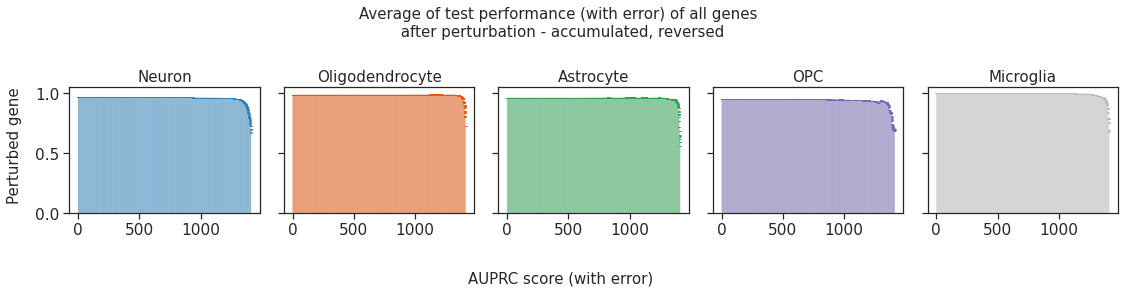

In [9]:
fig, axs  = plt.subplots(1,5, figsize=(16, 4), sharex=True, sharey=True)
sns.set(font_scale=1.4, style='ticks')
for i in cell_types:
    number = cell_types.index(i)
    scores = score_list[number]
    scores_df = pd.DataFrame(scores)
    scores_df['mean'] = scores_df.mean(axis=1)
    scores_df['std'] = scores_df.std(axis=1)
    
    color=outer_colors[number]
    axs[number].bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
                    color=color, 
                    edgecolor=color,
                    alpha=0.8,
                    linewidth=0.005,
                    ecolor=color)
#     axs[number].set_yticks(np.arange(nr_coefs))
#     axs[number].set_yticklabels(top_features, style='italic', fontsize=12)
    
#     axs[number].set_xticks((round(min(top_coefs), 1), 0, round(max(top_coefs), 1)))

    axs[number].set_title(f'{i}', fontsize=15)

fig.supxlabel('AUPRC score (with error)', fontsize=15)
fig.supylabel( 'Perturbed gene', fontsize=15)
fig.suptitle('Average of test performance (with error) of all genes \n after perturbation - accumulated, reversed', fontsize=15)
plt.tight_layout()
#plt.savefig('../figures/4f_celltype_perturbation_colored.pdf')